In [1]:
#!/usr/bin/env python
# coding: utf-8


"""
Follows 
https://www.tensorflow.org/tutorials/text/text_classification_rnn
and 
https://www.tensorflow.org/tutorials/text/classify_text_with_bert
"""
import glob
import os
import pickle as pkl
import random
import re
import sys
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
# For pre-trained embeddings:
import tensorflow_hub as hub
import tensorflow_text as text

In [2]:
datetime.now()

datetime.datetime(2021, 1, 18, 18, 15, 49, 294361)

In [3]:
EXP_NUM = 18
# How much it loads into memory for sampling
BUFFER_SIZE = 10000
# Batch for gradient averaging
BATCH_SIZE = 64
# Specify encoding of words
SUBSET_VOCAB_SIZE = 5000
OUTPUT_DIR = '/rds/general/user/al3615/home/RNN_for_movie_gross_prediction/jobs/pretrained_embeddings/outputs'
GROSS_SYNOPSES_PATH = '/rds/general/user/al3615/home/RNN_for_movie_gross_prediction/complete10000_films_and_synopsis.pickle'

In [4]:
def plot_graphs(history, metric, name):
    fig, ax1 = plt.subplots(figsize=(8.0, 5.0))

    color = "tab:red"
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(metric, color=color)
    ax1.plot(history.history[metric], color=color)
    ax1.tick_params(axis="y", labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = "tab:blue"
    ax2.set_ylabel(
        "val_" + metric, color=color
    )  # we already handled the x-label with ax1
    ax2.plot(history.history["val_" + metric], color=color)
    ax2.tick_params(axis="y", labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.legend([metric, "val_" + metric])
    plt.savefig(f"{OUTPUT_DIR}/{name}.png", dpi=300)


def split_data_into_input_and_output(data):
    """Take given data of format from scraper [link] and return the inputs and outputs seperated.

    Args:
        data (list): A numpy array/list of named tuples which contains entries for 'gross',
        'title', 'synopsis' and 'year'.
    """
    data_in, data_out = list(zip(*[((x["synopsis"]), x["gross"]) for x in data]))
    return np.array(data_in), np.array(data_out)


def add_signal(data):
    """
    If the given data has no signal we cant fit a NN to it. As such, here we append how much the film grossed
    into the synopsis of each title.

    Args:
        data (list): A numpy array/list of named tuples which contains entries for 'gross',
        'title', 'synopsis' and 'year'.
    """
    for row in data:
        row["synopsis"] = row["synopsis"] + f' The film grossed ${row["gross"]}'


def clean_copy(data, min_length=10, max_length=50, min_earning=0,max_earning=np.exp(18)):
    cleaned_data = np.fromiter(
        (x for x in data if len(x["synopsis"].split()) > min_length), dtype=data.dtype
    )
    print(
        f"Crushed {len(data)} to {len(cleaned_data)} after removing sub {min_length} word synopses"
    )
    old_len = len(cleaned_data)

    cleaned_data = np.fromiter(
        (x for x in cleaned_data if len(x["synopsis"].split()) < max_length), dtype=data.dtype
    )
    print(
        f"Crushed {old_len} to {len(cleaned_data)} after removing super {max_length} word synopses"
    )
    old_len = len(cleaned_data)

    cleaned_data = np.fromiter(
        (x for x in cleaned_data if x['gross'] > min_earning), dtype=data.dtype
    )
    print(
        f"Crushed {old_len} to {len(cleaned_data)} after removing sub {min_earning} gross"
    )
    old_len = len(cleaned_data)

    cleaned_data = np.fromiter(
        (x for x in cleaned_data if x['gross'] < max_earning), dtype=data.dtype
    )
    print(
        f"Crushed {old_len} to {len(cleaned_data)} after removing super {max_earning} gross"
    )
    old_len = len(cleaned_data)

    return cleaned_data


def confusion_plot(lab, pred, name):
    """
    Helper function to pile on scatter plots of labels and predictions that are real numbers
    marking a helpful black line for the truth

    lab = label
    pred = prediction

    needs a call to plt.show() or plt.savefig() after it cumulatively builds this
    """
    plt.scatter(lab, lab, label="truth", s=2, color="black")
    plt.scatter(lab, pred, label=name, s=2)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.xlabel("Truth")
    plt.ylabel("Prediction")

In [5]:
raw_data = pkl.load(open(GROSS_SYNOPSES_PATH, "rb"))
real_data = clean_copy(raw_data)
real_data["gross"] = np.log(real_data["gross"])

# Ensures that not only a certain gross of film make it into train/test sets respectively
np.random.shuffle(real_data)
data = real_data

# Fraction of overall data
training_fraction = 0.85
train_end = int(len(data) * training_fraction)
train_data_in, train_data_out = split_data_into_input_and_output(data[:train_end])
test_data_in, test_data_out = split_data_into_input_and_output(data[train_end:])

# Make dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((train_data_in, train_data_out))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data_in, test_data_out))

# Prefetch parrallelising loading + execution (not huge so not necessary)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(5)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(5)

Crushed 10000 to 9742 after removing sub 10 word synopses
Crushed 9742 to 9209 after removing super 50 word synopses
Crushed 9209 to 9209 after removing sub 0 gross
Crushed 9209 to 7988 after removing super 65659969.13733051 gross


In [6]:
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=SUBSET_VOCAB_SIZE, ngrams=1
)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
# Specify overall architecture
model = tf.keras.Sequential(
    [
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(0.01),
)

In [8]:
checkpoint_dir = f"{OUTPUT_DIR}/checkpoints"
checkpoint_path = f"{checkpoint_dir}/{{epoch:04d}}_ckpt"
# Create a callback that saves the model's weights every epoch
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_freq=10 * len(train_data_in) // BATCH_SIZE,
)

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset,
    validation_steps=len(test_data_in) // BATCH_SIZE,
    callbacks=[cp_callback],
    verbose=1,
)

Epoch 1/50
107/107 [==============================] - 13s 126ms/step - loss: 15.1506 - val_loss: 2.5762
Epoch 2/50
107/107 [==============================] - 9s 82ms/step - loss: 2.4415 - val_loss: 2.6547
Epoch 3/50
107/107 [==============================] - 8s 79ms/step - loss: 1.8436 - val_loss: 2.8311
Epoch 4/50
107/107 [==============================] - 9s 84ms/step - loss: 1.5418 - val_loss: 3.3867
Epoch 5/50
107/107 [==============================] - 9s 82ms/step - loss: 1.2811 - val_loss: 3.3110
Epoch 6/50
107/107 [==============================] - 9s 81ms/step - loss: 0.9847 - val_loss: 3.8626
Epoch 7/50
107/107 [==============================] - 8s 77ms/step - loss: 0.8357 - val_loss: 3.5468
Epoch 8/50
107/107 [==============================] - 8s 77ms/step - loss: 0.5938 - val_loss: 3.7291
Epoch 9/50
107/107 [==============================] - 9s 80ms/step - loss: 1.6461 - val_loss: 4.4529
Epoch 10/50
 96/107 [=========================>....] - ETA: 0s - loss: 1.5232
Epoch 0001

KeyboardInterrupt: 

NameError: name 'history' is not defined

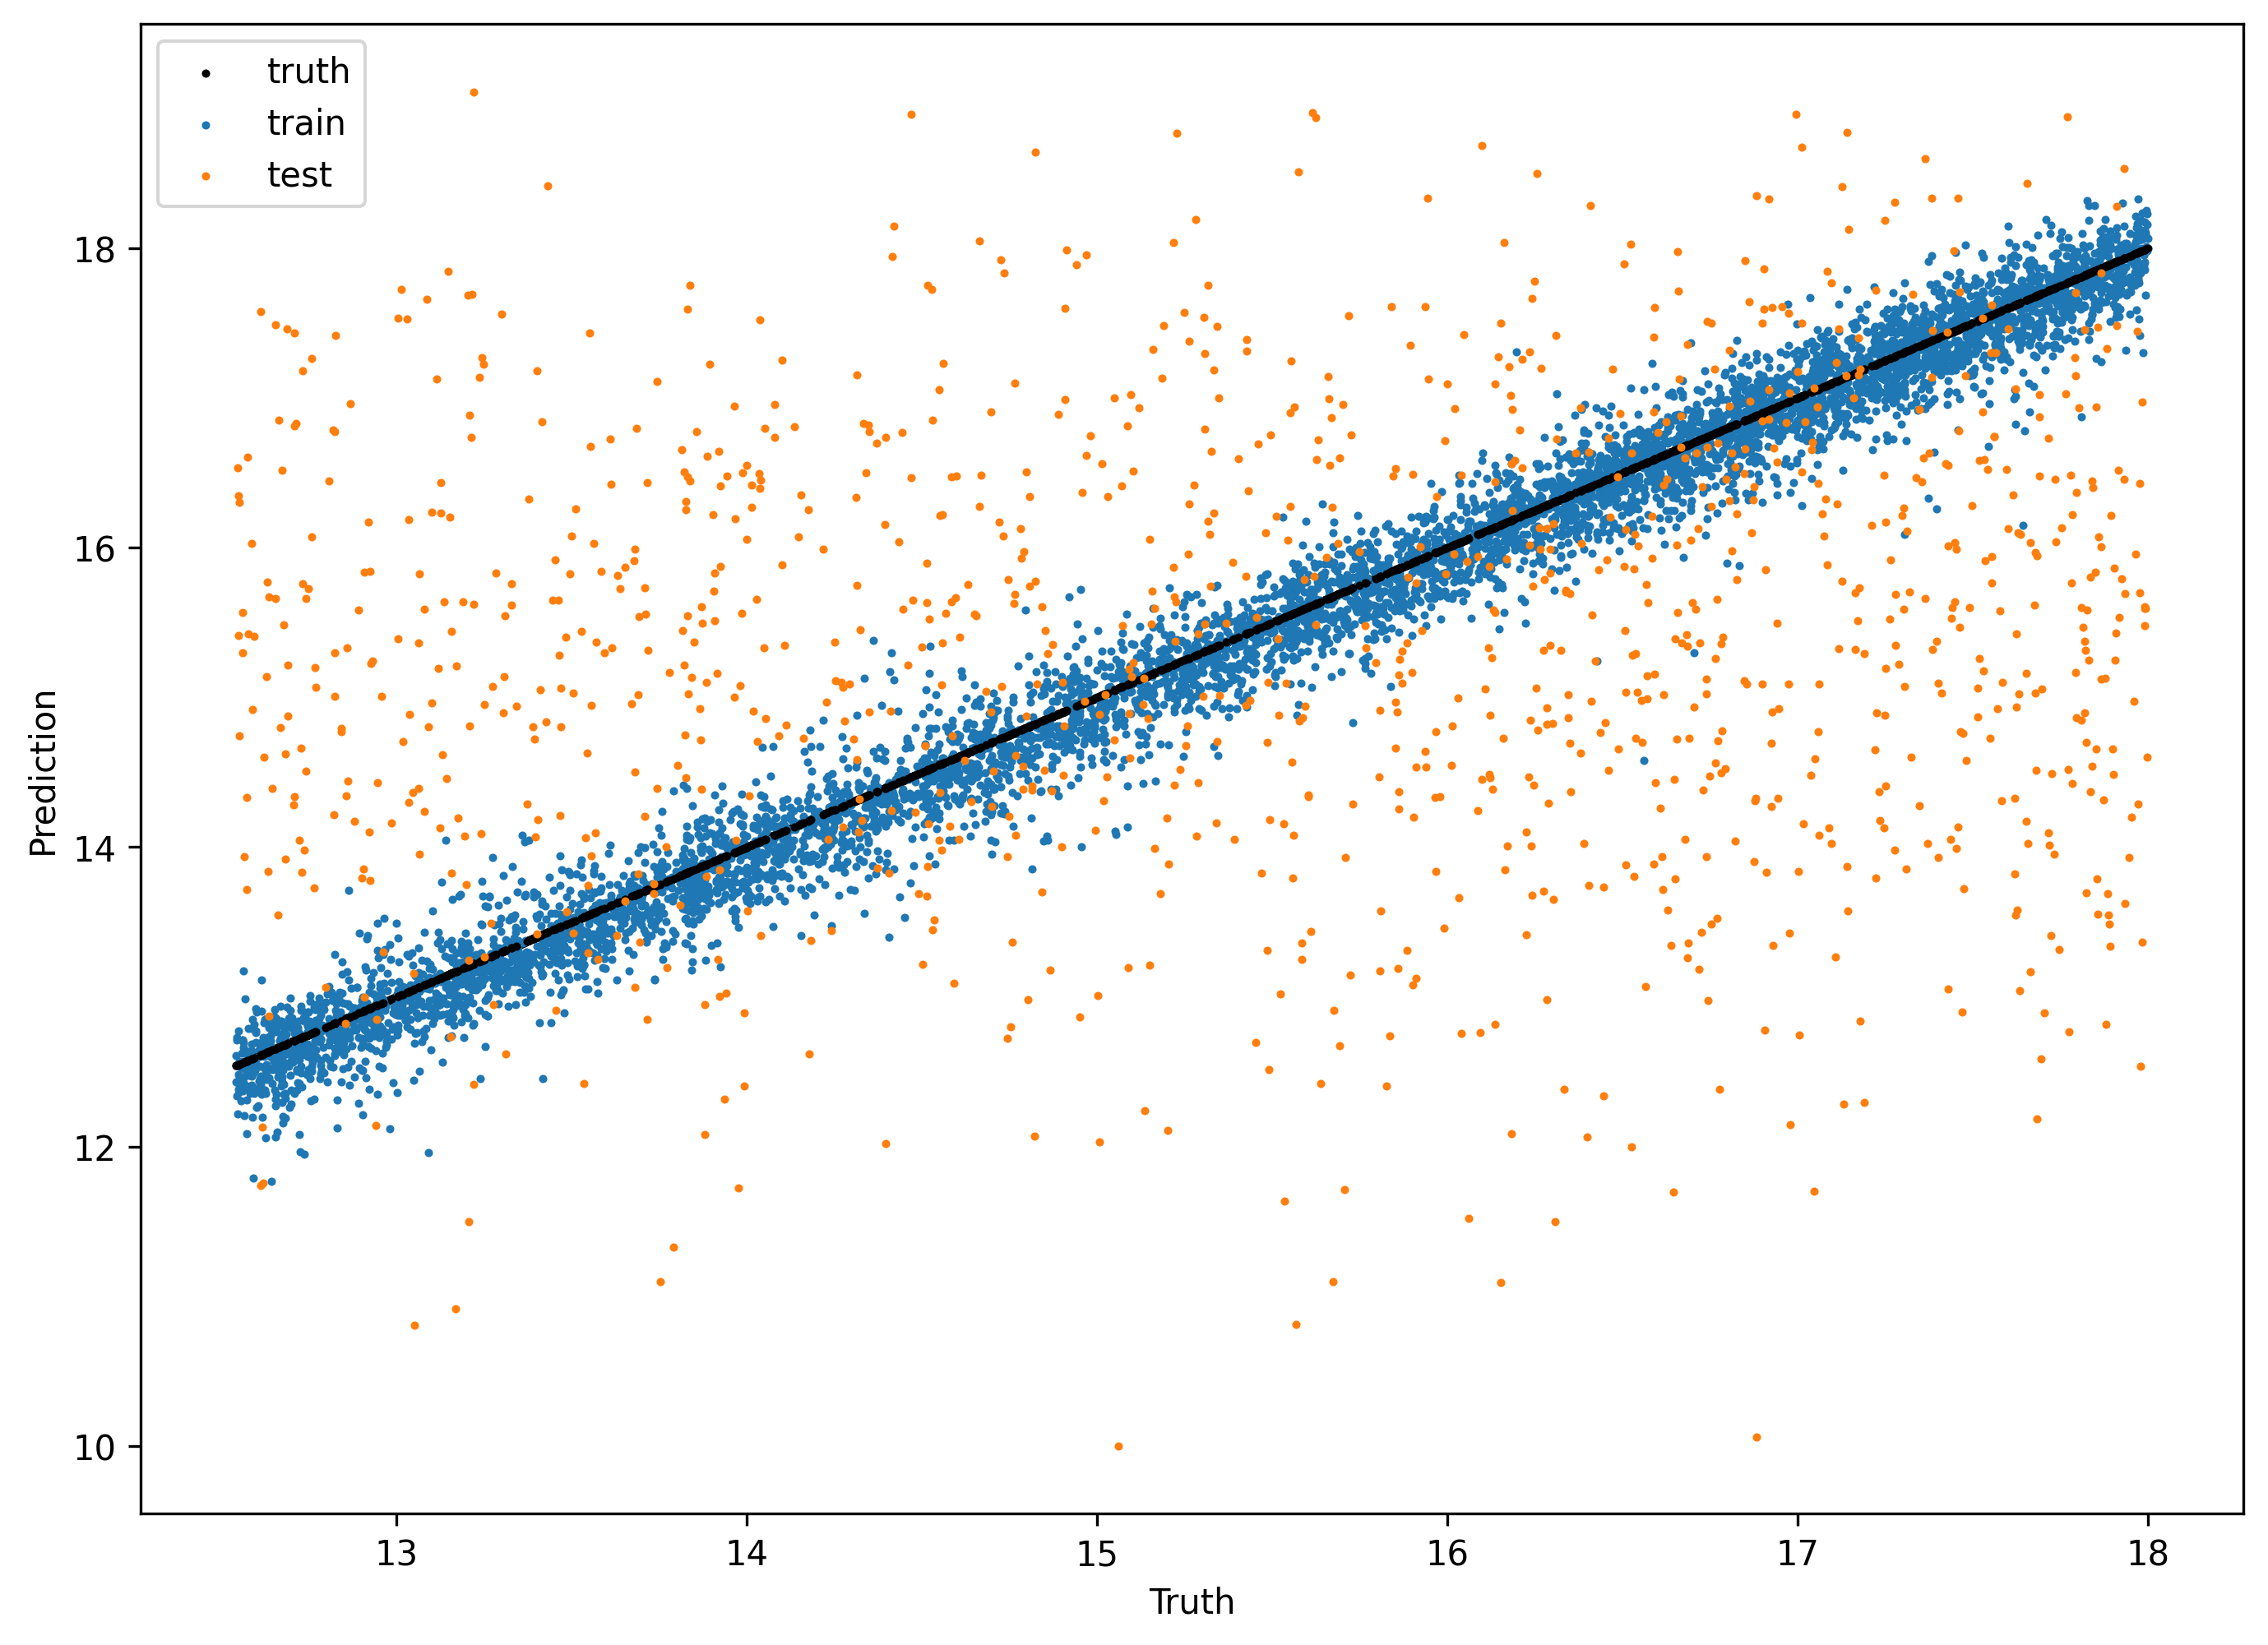

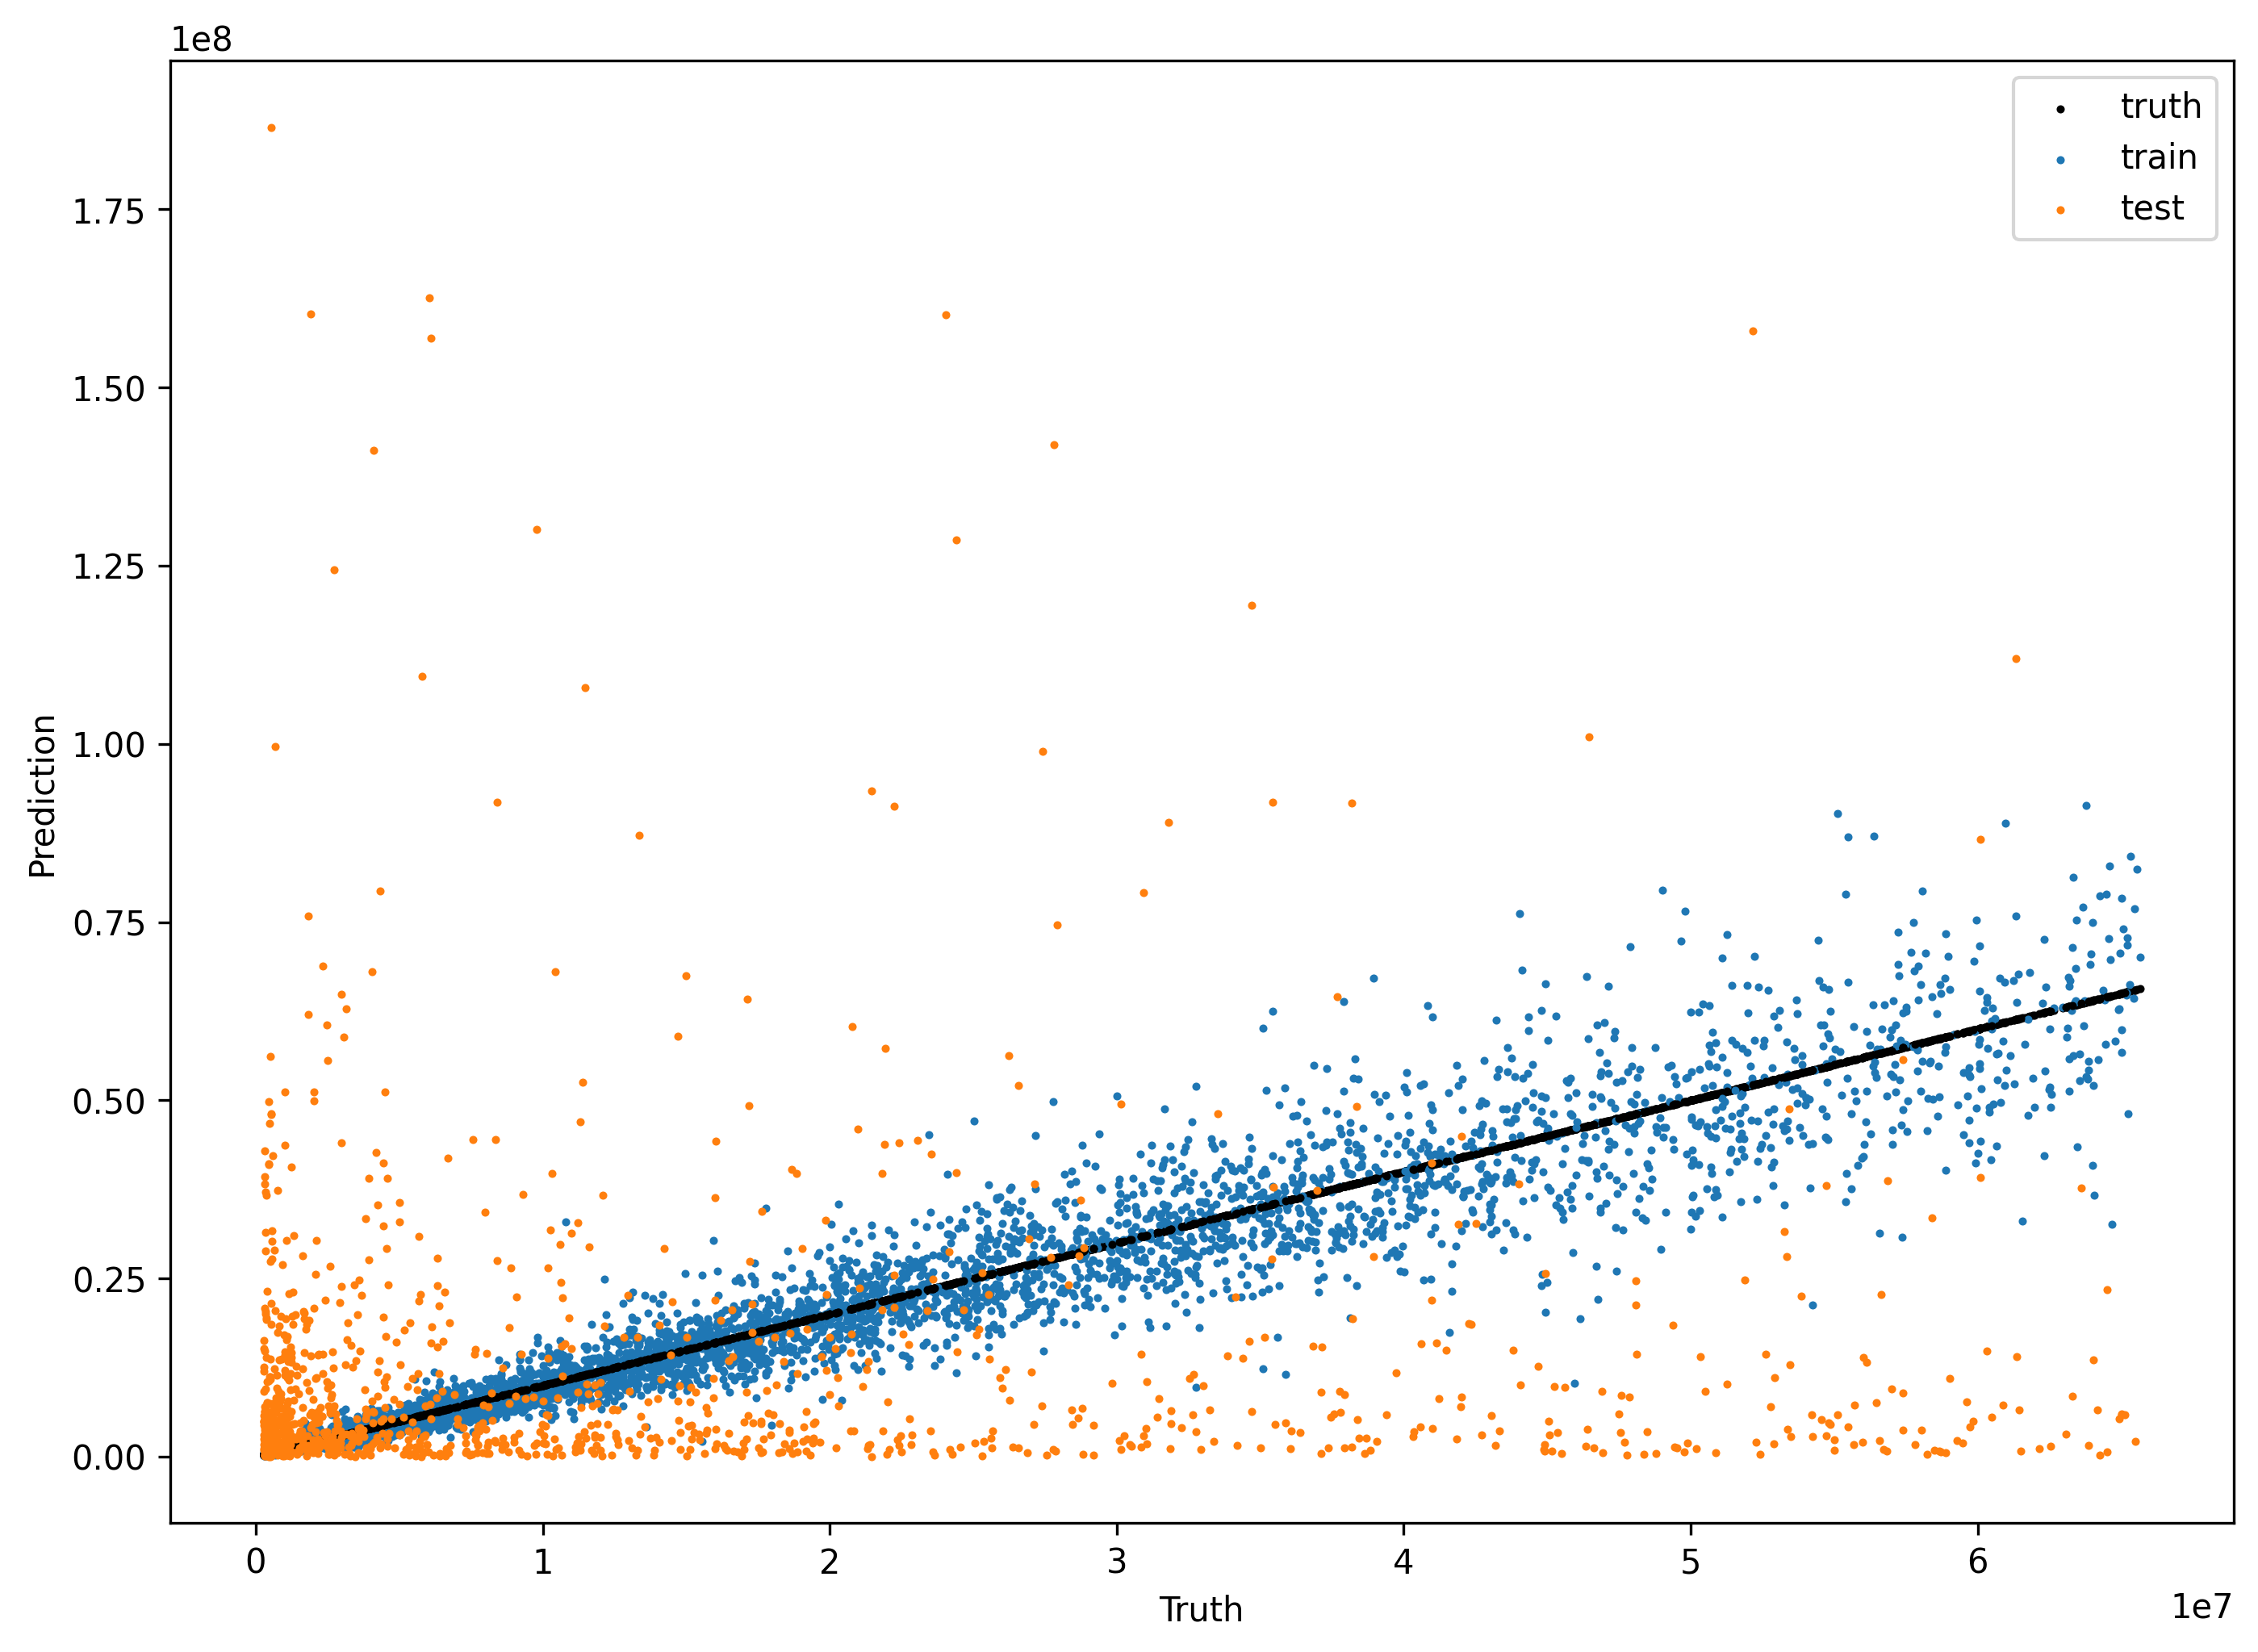

In [9]:
# Look at performance
plt.figure(figsize=(11, 8), dpi=300)
pred_train = model.predict(train_data_in)
confusion_plot(train_data_out, pred_train, f"train")
pred_test = model.predict(test_data_in)
confusion_plot(test_data_out, pred_test, f"test")
plt.savefig(f"{OUTPUT_DIR}/normal_confusion.png")
plt.figure(figsize=(11, 8), dpi=300)
confusion_plot(np.exp(train_data_out), np.exp(pred_train), f"train")
confusion_plot(np.exp(test_data_out), np.exp(pred_test), f"test")
plt.savefig(f"{OUTPUT_DIR}/normal_confusion_unlogged.png")
plot_graphs(history, "loss", "normal_loss")

In [10]:
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/2',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
}

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2


In [11]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dense(64, activation='relu', name='hidden-1')(net)
  net = tf.keras.layers.Dense(64, activation='relu', name='hidden-2')(net)
  net = tf.keras.layers.Dense(1, name='classifier')(net)
  return tf.keras.Model(text_input, net)

pre_trained_model = build_classifier_model()
pre_trained_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(0.01),
)

In [12]:
checkpoint_dir = f"{OUTPUT_DIR}/pre_trained_checkpoints"
checkpoint_path = f"{checkpoint_dir}/{{epoch:04d}}_ckpt"
# Create a callback that saves the model's weights every 10 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_freq=10 * len(train_data_in) // BATCH_SIZE,
)

pre_trained_history = pre_trained_model.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset,
    validation_steps=len(test_data_in) // BATCH_SIZE,
    callbacks=[cp_callback],
    verbose=1,
)

Epoch 1/50
107/107 [==============================] - 302s 3s/step - loss: 9.1042 - val_loss: 2.8901
Epoch 2/50
107/107 [==============================] - 297s 3s/step - loss: 2.6162 - val_loss: 3.3414
Epoch 3/50
107/107 [==============================] - 297s 3s/step - loss: 2.5762 - val_loss: 3.0542
Epoch 4/50
107/107 [==============================] - 287s 3s/step - loss: 2.5243 - val_loss: 2.3843
Epoch 5/50
107/107 [==============================] - 284s 3s/step - loss: 2.4810 - val_loss: 2.3891
Epoch 6/50
107/107 [==============================] - 287s 3s/step - loss: 2.4300 - val_loss: 4.0008
Epoch 7/50
107/107 [==============================] - 284s 3s/step - loss: 2.5375 - val_loss: 2.5780
Epoch 8/50
107/107 [==============================] - 287s 3s/step - loss: 2.5278 - val_loss: 2.3696
Epoch 9/50
107/107 [==============================] - 286s 3s/step - loss: 2.4481 - val_loss: 2.6410
Epoch 10/50
 96/107 [=========================>....] - ETA: 24s - loss: 2.4358
Epoch 00010:

INFO:tensorflow:Assets written to: /rds/general/user/al3615/home/RNN_for_movie_gross_prediction/jobs/pretrained_embeddings/outputs/pre_trained_checkpoints/0010_ckpt/assets


107/107 [==============================] - 296s 3s/step - loss: 2.4537 - val_loss: 2.3795
Epoch 11/50
107/107 [==============================] - 290s 3s/step - loss: 2.3049 - val_loss: 2.5735
Epoch 12/50
107/107 [==============================] - 288s 3s/step - loss: 2.3748 - val_loss: 2.4842
Epoch 13/50
107/107 [==============================] - 280s 3s/step - loss: 2.4035 - val_loss: 2.4256
Epoch 14/50
107/107 [==============================] - 285s 3s/step - loss: 2.4491 - val_loss: 2.4845
Epoch 15/50
107/107 [==============================] - 286s 3s/step - loss: 2.4233 - val_loss: 3.2146
Epoch 16/50
107/107 [==============================] - 287s 3s/step - loss: 2.5312 - val_loss: 3.6428
Epoch 17/50
107/107 [==============================] - 290s 3s/step - loss: 2.3426 - val_loss: 2.3571
Epoch 18/50
107/107 [==============================] - 294s 3s/step - loss: 2.3382 - val_loss: 2.3813
Epoch 19/50
107/107 [==============================] - 289s 3s/step - loss: 2.3698 - val_loss:

INFO:tensorflow:Assets written to: /rds/general/user/al3615/home/RNN_for_movie_gross_prediction/jobs/pretrained_embeddings/outputs/pre_trained_checkpoints/0020_ckpt/assets


107/107 [==============================] - 299s 3s/step - loss: 2.2678 - val_loss: 2.4244
Epoch 21/50
107/107 [==============================] - 283s 3s/step - loss: 2.2771 - val_loss: 2.8921
Epoch 22/50
107/107 [==============================] - 278s 3s/step - loss: 2.3217 - val_loss: 2.5288
Epoch 23/50
107/107 [==============================] - 283s 3s/step - loss: 2.3348 - val_loss: 2.5859
Epoch 24/50
107/107 [==============================] - 286s 3s/step - loss: 2.2313 - val_loss: 2.4592
Epoch 25/50
107/107 [==============================] - 290s 3s/step - loss: 2.1683 - val_loss: 2.4614
Epoch 26/50
107/107 [==============================] - 289s 3s/step - loss: 2.1690 - val_loss: 2.6647
Epoch 27/50
107/107 [==============================] - 289s 3s/step - loss: 2.2528 - val_loss: 2.4564
Epoch 28/50
107/107 [==============================] - 286s 3s/step - loss: 2.2436 - val_loss: 2.4152
Epoch 29/50
107/107 [==============================] - 286s 3s/step - loss: 2.1647 - val_loss:

INFO:tensorflow:Assets written to: /rds/general/user/al3615/home/RNN_for_movie_gross_prediction/jobs/pretrained_embeddings/outputs/pre_trained_checkpoints/0030_ckpt/assets


107/107 [==============================] - 297s 3s/step - loss: 2.1490 - val_loss: 2.3987
Epoch 31/50
107/107 [==============================] - 286s 3s/step - loss: 2.1906 - val_loss: 2.4083
Epoch 32/50
107/107 [==============================] - 286s 3s/step - loss: 2.1710 - val_loss: 2.4115
Epoch 33/50
107/107 [==============================] - 286s 3s/step - loss: 2.2129 - val_loss: 2.4723
Epoch 34/50
107/107 [==============================] - 287s 3s/step - loss: 2.0697 - val_loss: 2.4519
Epoch 35/50
107/107 [==============================] - 289s 3s/step - loss: 2.0952 - val_loss: 4.9820
Epoch 36/50
107/107 [==============================] - 291s 3s/step - loss: 2.2242 - val_loss: 2.6312
Epoch 37/50
107/107 [==============================] - 290s 3s/step - loss: 2.1999 - val_loss: 3.3912
Epoch 38/50
107/107 [==============================] - 289s 3s/step - loss: 2.1723 - val_loss: 2.6055
Epoch 39/50
107/107 [==============================] - 292s 3s/step - loss: 2.1189 - val_loss:

INFO:tensorflow:Assets written to: /rds/general/user/al3615/home/RNN_for_movie_gross_prediction/jobs/pretrained_embeddings/outputs/pre_trained_checkpoints/0040_ckpt/assets


107/107 [==============================] - 306s 3s/step - loss: 2.0536 - val_loss: 2.6622
Epoch 41/50
107/107 [==============================] - 292s 3s/step - loss: 2.0486 - val_loss: 2.5754
Epoch 42/50
107/107 [==============================] - 295s 3s/step - loss: 2.0573 - val_loss: 2.8630
Epoch 43/50
107/107 [==============================] - 290s 3s/step - loss: 2.0342 - val_loss: 3.4710
Epoch 44/50
107/107 [==============================] - 293s 3s/step - loss: 2.0202 - val_loss: 2.4790
Epoch 45/50
107/107 [==============================] - 292s 3s/step - loss: 2.0260 - val_loss: 2.4513
Epoch 46/50
107/107 [==============================] - 289s 3s/step - loss: 1.9933 - val_loss: 2.6318
Epoch 47/50
107/107 [==============================] - 288s 3s/step - loss: 2.0650 - val_loss: 2.4662
Epoch 48/50
107/107 [==============================] - 290s 3s/step - loss: 2.0500 - val_loss: 2.6001
Epoch 49/50
107/107 [==============================] - 288s 3s/step - loss: 1.9517 - val_loss:

INFO:tensorflow:Assets written to: /rds/general/user/al3615/home/RNN_for_movie_gross_prediction/jobs/pretrained_embeddings/outputs/pre_trained_checkpoints/0050_ckpt/assets


107/107 [==============================] - 304s 3s/step - loss: 1.9505 - val_loss: 2.6036


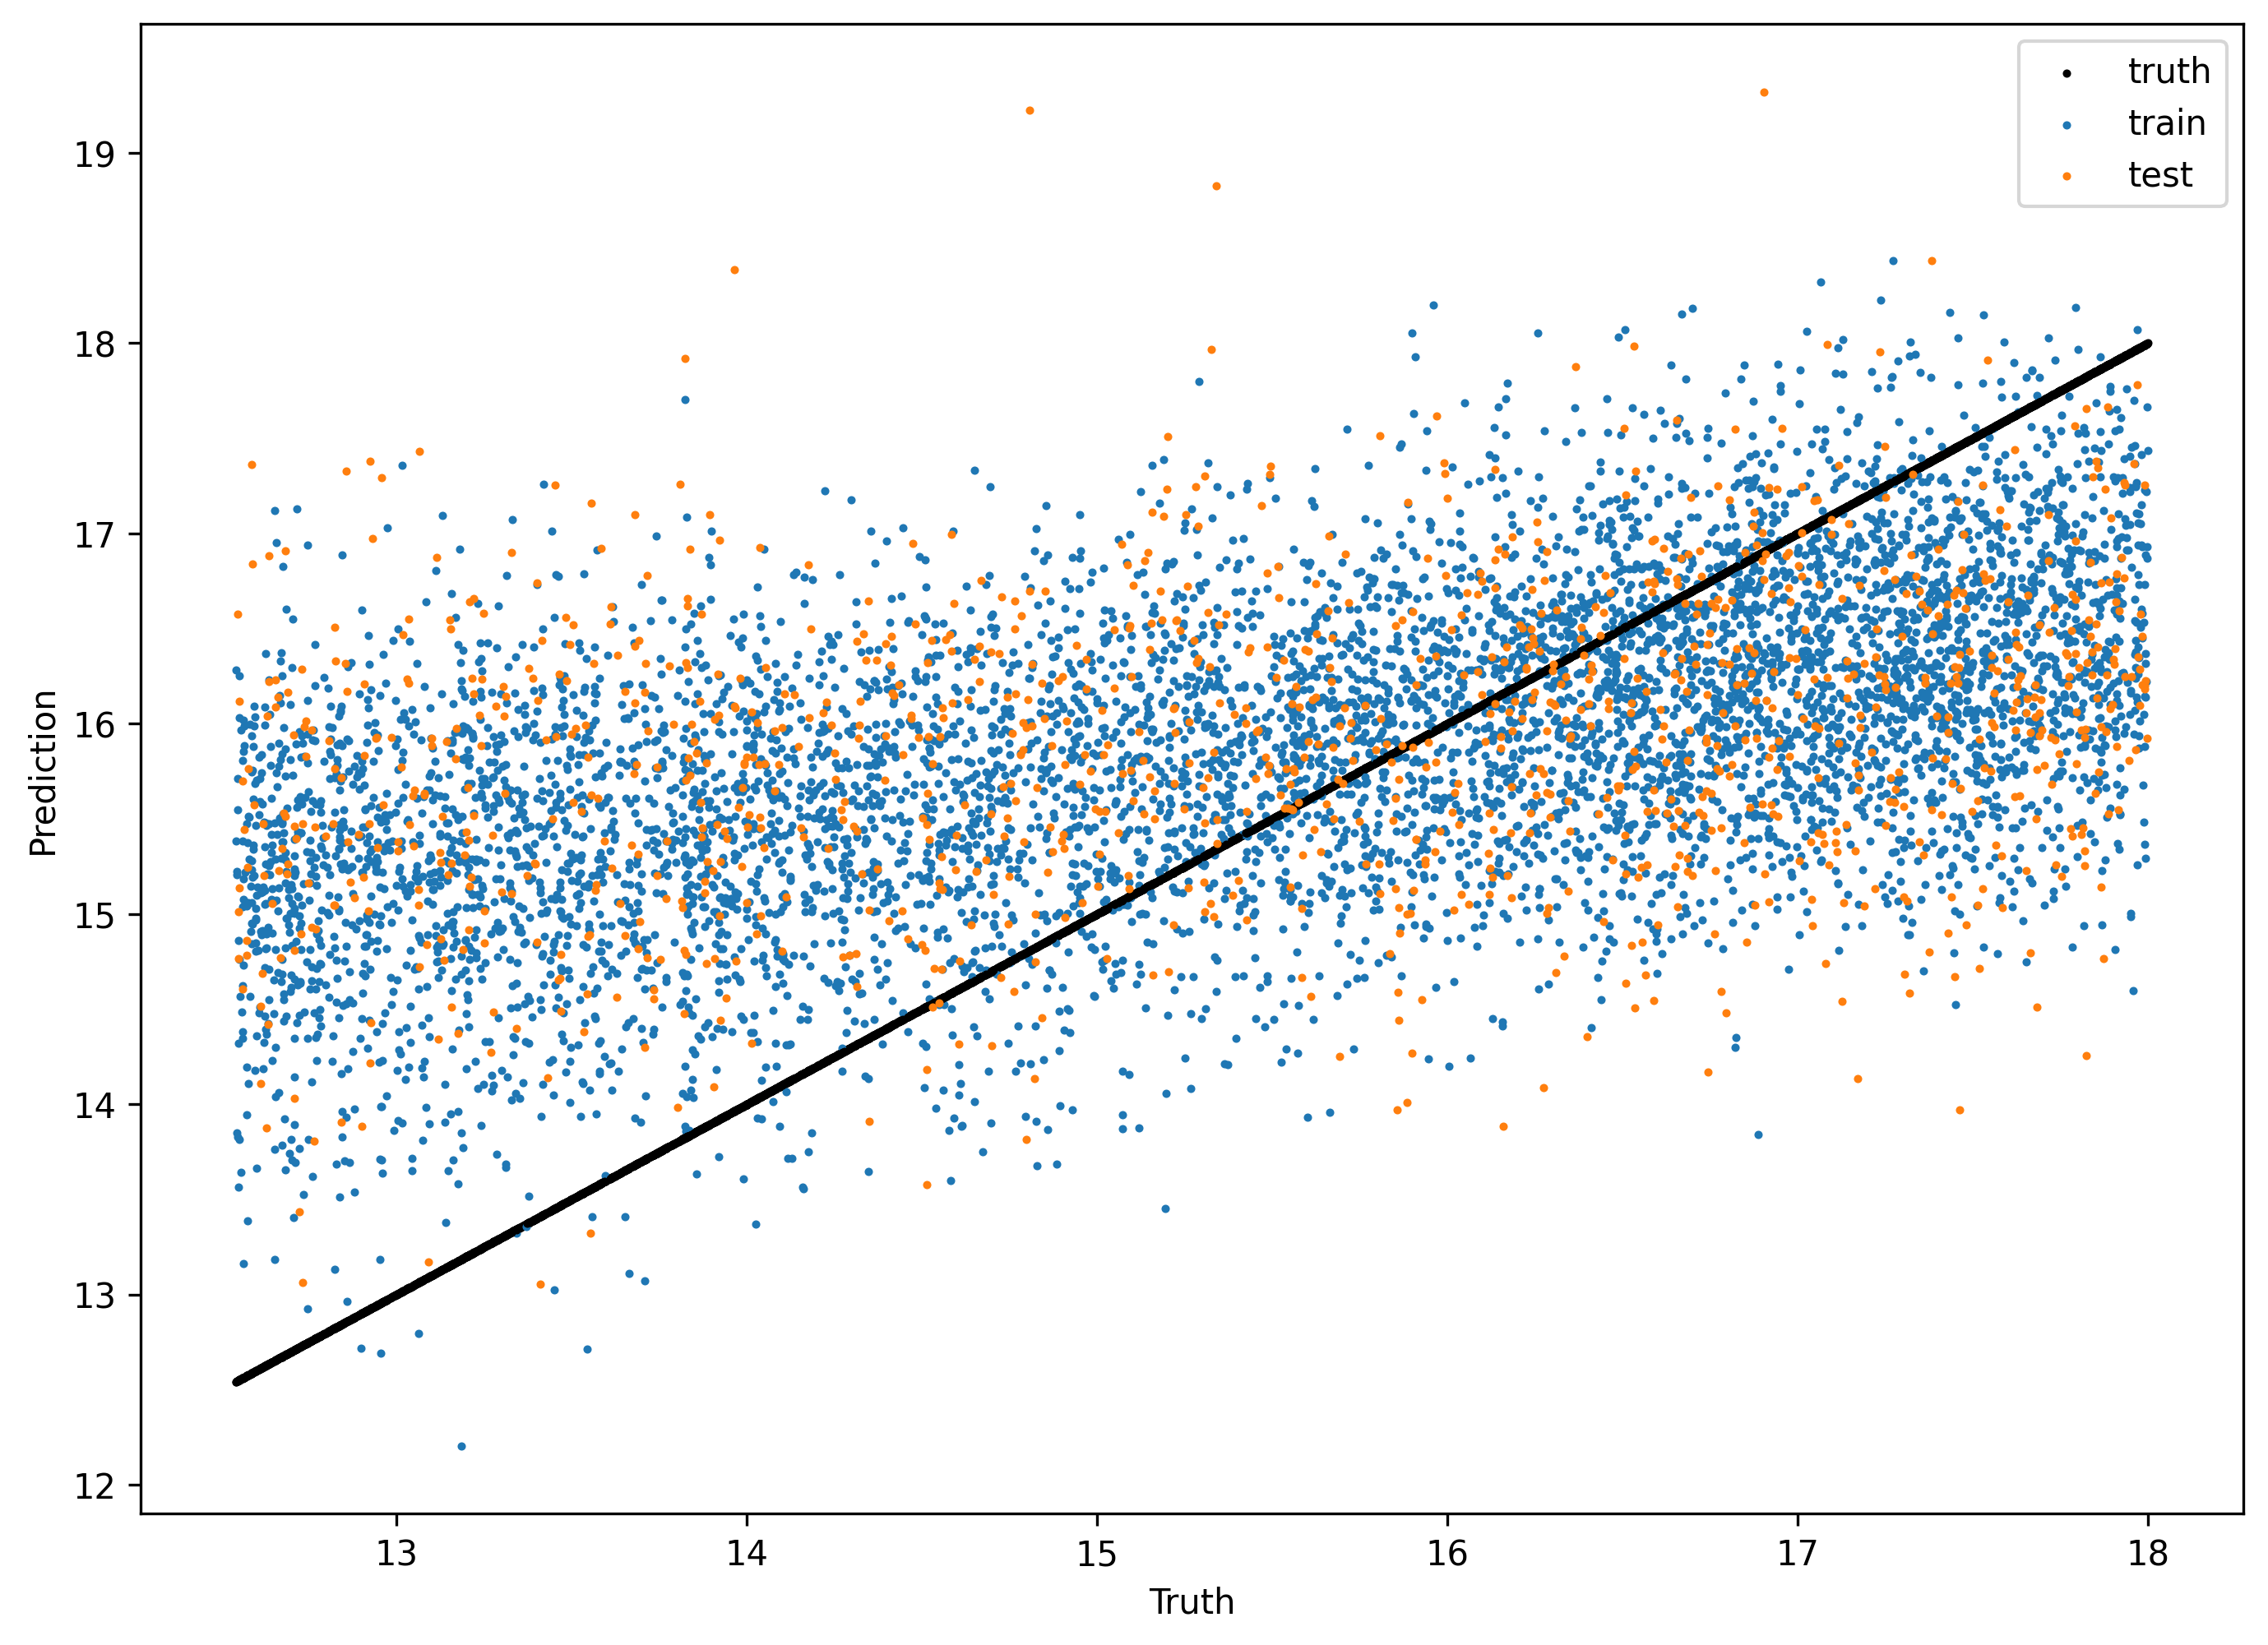

In [13]:
plt.figure(figsize=(11, 8), dpi=300)
pred_train = pre_trained_model.predict(train_data_in)
confusion_plot(train_data_out, pred_train, f"train")
pred_test = pre_trained_model.predict(test_dataset)
confusion_plot(test_data_out, pred_test, f"test")
plt.savefig(f"{OUTPUT_DIR}/pretrained_confusion.png")

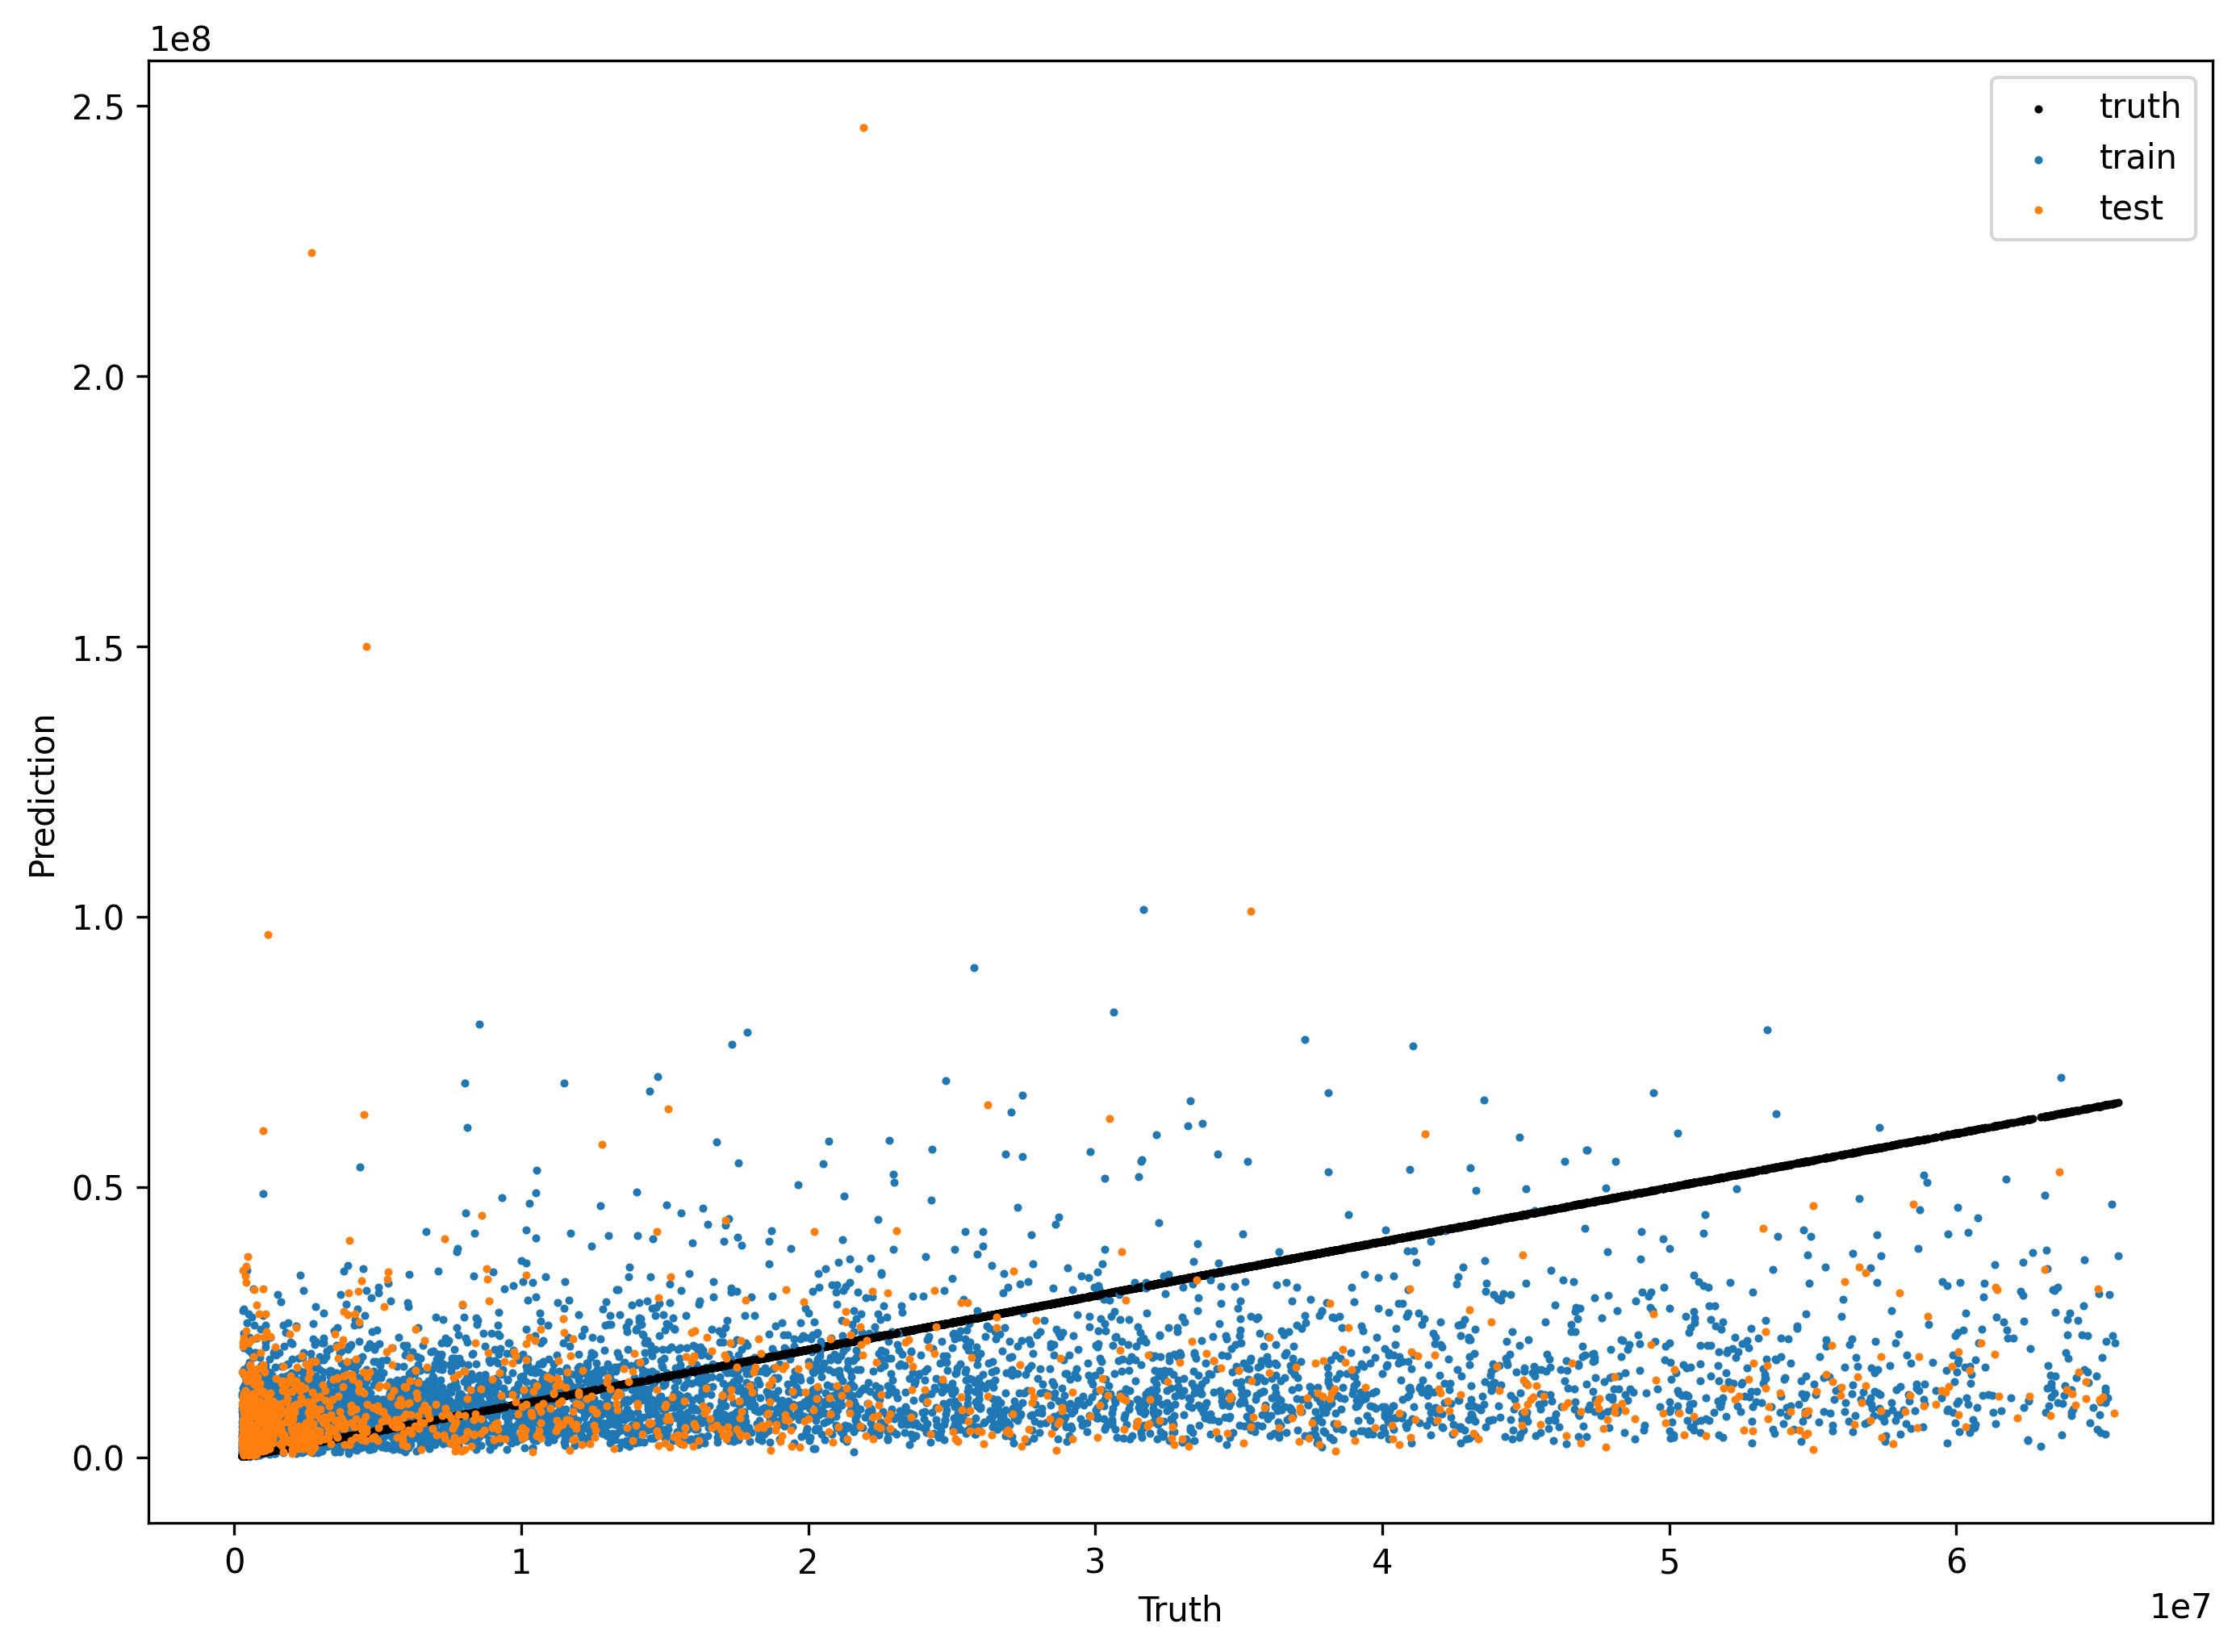

In [14]:
plt.figure(figsize=(11, 8), dpi=300)
confusion_plot(np.exp(train_data_out), np.exp(pred_train), f"train")
confusion_plot(np.exp(test_data_out), np.exp(pred_test), f"test")
plt.savefig(f"{OUTPUT_DIR}/pretrained_confusion_unlogged.png")

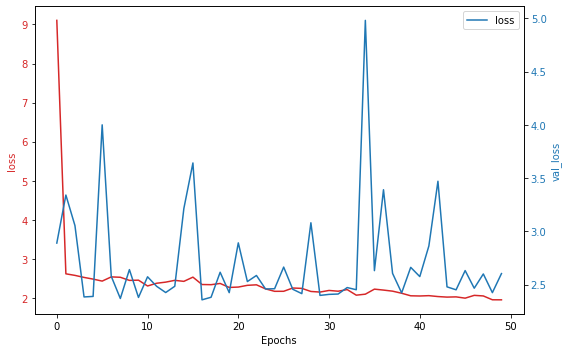

In [15]:
plot_graphs(pre_trained_history, "loss", "pretrained_loss")

In [ ]:
old_model = f"RNN_for_movie_gross_prediction/jobs/pretrained_embeddings/outputs/2021-01-21-2020/pre_trained_checkpoints"
model = tf.